In [ ]:
import pandas as pd
import numpy as np
import jpholiday

# -----------------------------
# 1. データ読み込み（Shift-JIS）
# -----------------------------
weather = pd.read_csv("weather.csv", encoding="shift_jis")
demand = pd.read_csv("demand.csv", encoding="shift_jis")

# -----------------------------
# 2. 列名を英語に変換（扱いやすくする）
# -----------------------------
weather = weather.rename(columns={
    "日付": "date",
    "平均気温(℃)": "avg_temp",
    "最高気温(℃)": "max_temp",
    "最低気温(℃)": "min_temp",
    "天気概況": "weather"
})

demand = demand.rename(columns={
    "日付": "date",
    "最大需要(MW)": "demand"
})

# 日付をdatetime型へ
weather["date"] = pd.to_datetime(weather["date"])
demand["date"] = pd.to_datetime(demand["date"])

# -----------------------------
# 3. 欠損値補完（気温）
# -----------------------------
weather[["avg_temp", "max_temp", "min_temp"]] = \
    weather[["avg_temp", "max_temp", "min_temp"]].interpolate()

# -----------------------------
# 4. データ結合（日付キー）
# -----------------------------
df = pd.merge(weather, demand, on="date")

# -----------------------------
# 5. 曜日・祝日フラグ追加
# -----------------------------
df["weekday"] = df["date"].dt.weekday
df["is_holiday"] = df["date"].apply(lambda x: 1 if jpholiday.is_holiday(x) else 0)

# -----------------------------
# 6. 天気を簡易カテゴリ化（重要）
# -----------------------------
def weather_simple(w):
    if "雪" in w:
        return "snow"
    elif "雨" in w:
        return "rain"
    elif "晴" in w:
        return "sunny"
    else:
        return "cloudy"

df["weather"] = df["weather"].apply(weather_simple)

# ワンホットエンコーディング
df = pd.get_dummies(df, columns=["weather"], drop_first=True)

# -----------------------------
# 7. 不要列削除
# -----------------------------
df = df.drop(columns=["date"])

# -----------------------------
# 8. 保存
# -----------------------------
df.to_csv("ml_ready_data.csv", index=False)

print(df.head())
print("前処理完了 → ml_ready_data.csv を作成しました")


   avg_temp  max_temp  min_temp  demand  weekday  is_holiday  weather_rain  \
0     -12.0      -9.2     -15.7     483        2           1         False   
1      -7.8      -2.5     -15.2     476        3           0         False   
2      -7.8      -4.4     -10.3     493        4           0         False   
3      -7.2      -4.0      -9.9     491        5           0         False   
4      -6.7      -3.5     -12.5     482        6           0         False   

   weather_snow  weather_sunny  
0          True          False  
1          True          False  
2          True          False  
3          True          False  
4          True          False  
前処理完了 → ml_ready_data.csv を作成しました


In [ ]:
か

Linear Regression RMSE: 36.80530352417745
Random Forest RMSE: 31.14356060445382


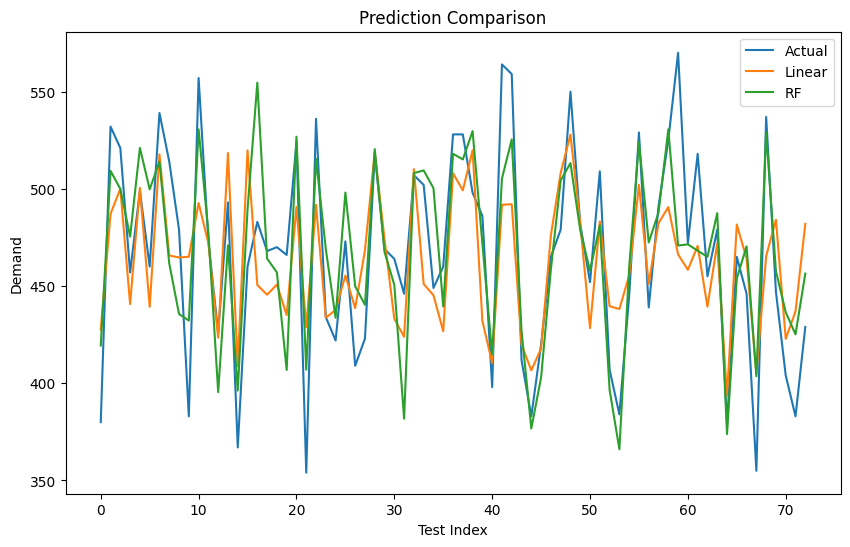

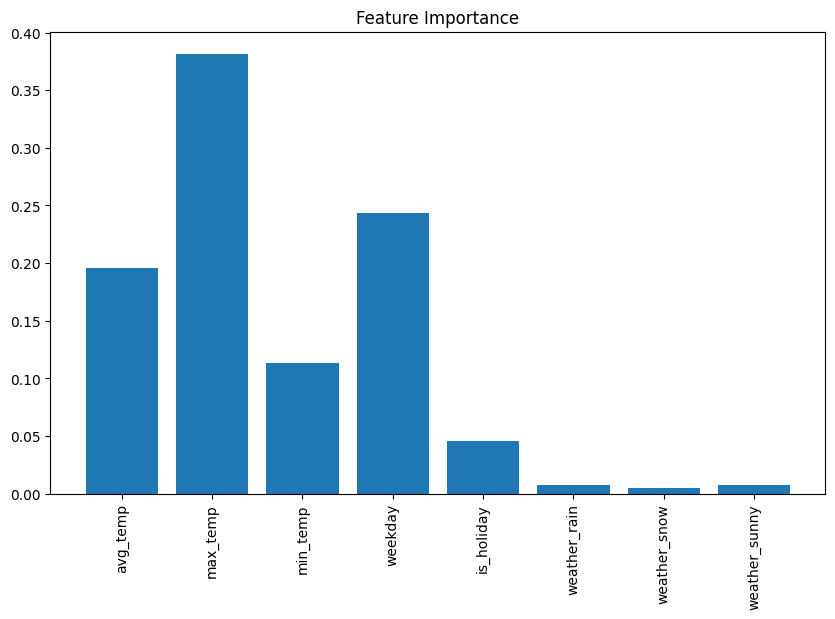

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# -----------------------------
# 1. データ読み込み
# -----------------------------
df = pd.read_csv("ml_ready_data.csv")

# -----------------------------
# 2. date列があれば削除（重要）
# -----------------------------
if "date" in df.columns:
    df = df.drop(columns=["date"])

# -----------------------------
# 3. 説明変数と目的変数
# -----------------------------
X = df.drop(columns=["demand"])
y = df["demand"]

# -----------------------------
# 4. 学習用・テスト用に分割
# -----------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# -----------------------------
# 5. 重回帰モデル
# -----------------------------
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print("Linear Regression RMSE:", rmse_lr)

# -----------------------------
# 6. ランダムフォレスト
# -----------------------------
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print("Random Forest RMSE:", rmse_rf)

# -----------------------------
# 7. 予測結果の比較グラフ
# -----------------------------
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred_lr, label="Linear")
plt.plot(y_pred_rf, label="RF")
plt.legend()
plt.xlabel("Test Index")
plt.ylabel("Demand")
plt.title("Prediction Comparison")
plt.show()

# -----------------------------
# 8. 特徴量の重要度（RF）
# -----------------------------
importances = rf.feature_importances_

plt.figure(figsize=(10,6))
plt.bar(X.columns, importances)
plt.xticks(rotation=90)
plt.title("Feature Importance")
plt.show()


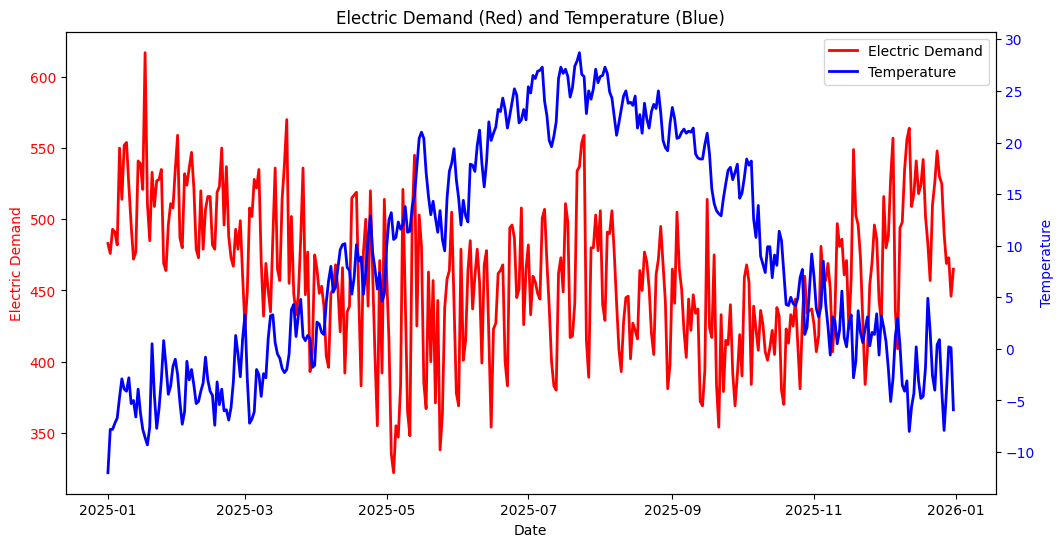

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ml_ready_data.csv には date 列が存在しないため、元のデータを読み込み直す
weather = pd.read_csv("weather.csv", encoding="shift_jis")
demand = pd.read_csv("demand.csv", encoding="shift_jis")

# 列名を英語に変換
weather = weather.rename(columns={
    "日付": "date",
    "平均気温(℃)": "avg_temp",
    "最高気温(℃)": "max_temp",
    "最低気温(℃)": "min_temp",
    "天気概況": "weather"
})

demand = demand.rename(columns={
    "日付": "date",
    "最大需要(MW)": "demand"
})

# 日付をdatetime型へ
weather["date"] = pd.to_datetime(weather["date"])
demand["date"] = pd.to_datetime(demand["date"])

# 欠損値補完（気温）
weather[["avg_temp", "max_temp", "min_temp"]] = \
    weather[["avg_temp", "max_temp", "min_temp"]].interpolate()

# データ結合（日付キー）
df_plot = pd.merge(weather, demand, on="date")

# 列名に合わせて修正
temperature_col = "avg_temp"  # 'avg_temp' 列を使用
demand_col = "demand"

fig, ax1 = plt.subplots(figsize=(12,6))

# 電力需要（赤）
ax1.plot(df_plot["date"], df_plot[demand_col],
         color="red", label="Electric Demand", linewidth=2)
ax1.set_xlabel("Date")
ax1.set_ylabel("Electric Demand", color="red")
ax1.tick_params(axis='y', labelcolor='red')

# 気温（青）
ax2 = ax1.twinx()
ax2.plot(df_plot["date"], df_plot[temperature_col],
         color="blue", label="Temperature", linewidth=2)
ax2.set_ylabel("Temperature", color="blue")
ax2.tick_params(axis='y', labelcolor='blue')

# 凡例をまとめる
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper right")

plt.title("Electric Demand (Red) and Temperature (Blue)")
plt.show()

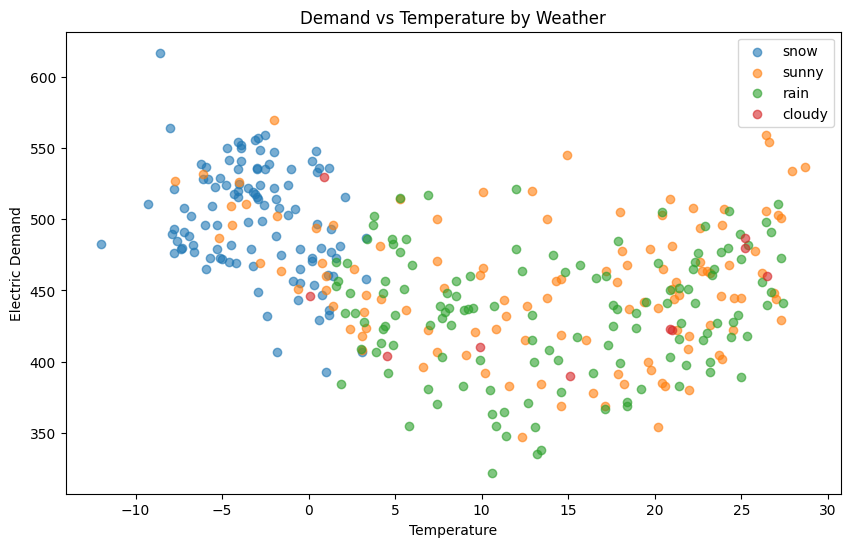

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("ml_ready_data.csv")

# Correct temperature column name to 'avg_temp'
temperature_col = "avg_temp"
demand_col = "demand"
# 'weather_col' as 'weather' does not exist due to one-hot encoding.
# Instead, we will reconstruct a simplified weather category.

# Reconstruct the simplified 'weather' category from one-hot encoded columns
def get_simplified_weather(row):
    if row["weather_rain"]:
        return "rain"
    elif row["weather_snow"]:
        return "snow"
    elif row["weather_sunny"]:
        return "sunny"
    else:
        return "cloudy" # 'cloudy' is implicitly the base category when others are false

df["simplified_weather"] = df.apply(get_simplified_weather, axis=1)

plt.figure(figsize=(10,6))

# Plot for each simplified weather category
for w in df["simplified_weather"].unique():
    subset = df[df["simplified_weather"] == w]
    plt.scatter(subset[temperature_col],
                subset[demand_col],
                label=w,
                alpha=0.6)

plt.xlabel("Temperature")
plt.ylabel("Electric Demand")
plt.title("Demand vs Temperature by Weather")
plt.legend()
plt.show()